In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

df = pd.read_csv(
    './Dataset/WineQT.csv',
)
X = df.iloc[:, :-2]
y = df.iloc[:, -2]

X = X.to_numpy()
y = y.to_numpy()

y = y - 3


scaler = StandardScaler()
scaler.fit(X)
def preprocess(data, scaler):
    return scaler.transform(data)

X = preprocess(X, scaler)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
X_train.shape

torch.Size([914, 11])

In [33]:
num_outputs = len(np.unique(y)) # 7

class QualityPredictor(nn.Module):
    def __init__(self):
        super(QualityPredictor, self).__init__()
        self.layer1 = nn.Linear(11, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, num_outputs)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# if torch.cuda.is_available():
#     device="cuda"
# else:
device="cpu"


# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 100

# Model, loss and optimizer
model = QualityPredictor().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-5
)

training_loss = []
validation_loss = []

# Early stopping parameters
best_val_loss = np.inf
patience = 10
trigger_times = 0

# Training loop
for epoch in range(num_epochs):
    print(f"E{epoch+1} running...")
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs=model(X_batch)
        loss=loss_fn(outputs, y_batch.to(device))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)

    epoch_loss /= len(X_train) / batch_size
    training_loss.append(epoch_loss)
    training_accuracy = correct_predictions / total_predictions
    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f'Training Loss: {epoch_loss:.4f} | Training Accuracy: {training_accuracy:.4f}')

    # Evaluation
    model.eval()
    with torch.inference_mode():
        test_outputs = model(X_test.to(device))
        test_loss=loss_fn(test_outputs, y_test.to(device))
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(
            y_test.cpu().numpy(),
            predicted.cpu().numpy()
        )
        validation_loss.append(test_loss.item())
        print(f"Validation loss: {test_loss:.4f} | Validation accuracy: {accuracy:.4f}")

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'Early stopping trigger times: {trigger_times}')
        if trigger_times >= patience:
            print("Early stopping!")
            break

E1 running...
Epoch: 1/100
Training Loss: 1.7393 | Training Accuracy: 0.3074
Validation loss: 1.5266 | Validation accuracy: 0.4629
E2 running...
Epoch: 2/100
Training Loss: 1.3776 | Training Accuracy: 0.5055
Validation loss: 1.1423 | Validation accuracy: 0.5153
E3 running...
Epoch: 3/100
Training Loss: 1.1401 | Training Accuracy: 0.5602
Validation loss: 1.0129 | Validation accuracy: 0.5590
E4 running...
Epoch: 4/100
Training Loss: 1.0664 | Training Accuracy: 0.5689
Validation loss: 0.9651 | Validation accuracy: 0.5808
E5 running...
Epoch: 5/100
Training Loss: 1.0289 | Training Accuracy: 0.5700
Validation loss: 0.9374 | Validation accuracy: 0.6114
E6 running...
Epoch: 6/100
Training Loss: 1.0046 | Training Accuracy: 0.5908
Validation loss: 0.9209 | Validation accuracy: 0.6245
E7 running...
Epoch: 7/100
Training Loss: 0.9865 | Training Accuracy: 0.6127
Validation loss: 0.9100 | Validation accuracy: 0.6201
E8 running...
Epoch: 8/100
Training Loss: 0.9717 | Training Accuracy: 0.6094
Valida

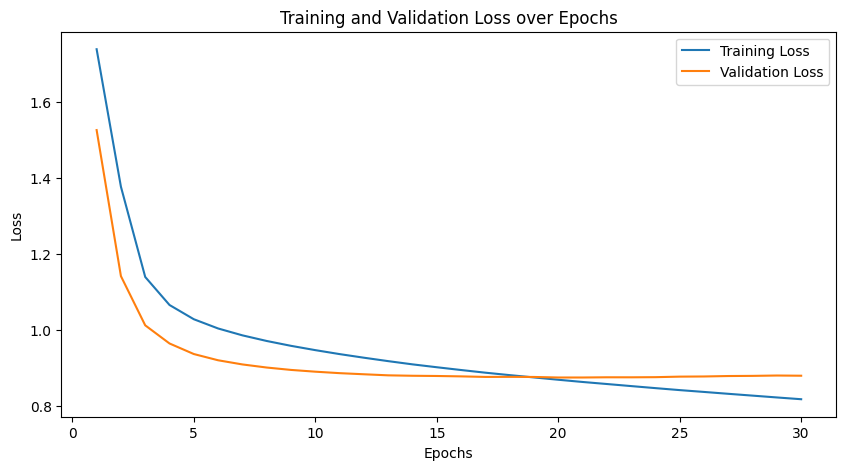

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_loss)+1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss)+1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()
